In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as sps
from scipy.integrate import quad
from scipy.special import gamma
import scipy.optimize as optimize

In [15]:
######################
# Realisation of AR(p) process
def ar_p(n, theta, sigma):
    x = np.random.normal(0,sigma,len(theta))
    #y = x.copy()
    for i in range(n):
        x = np.append(x,(np.sum(theta*x[-len(theta):][::-1])+np.random.normal(0,sigma,1)))
    data = pd.DataFrame(x,columns=['ar_p'])
    return data


######################
# Lower bound of confidence probability
def lb_conf_prob_ARp(y, p, z, n2):
    return sps.chi.cdf(z * (y / (n2 - 2)) ** 0.5, p) * sps.chi2.pdf(y,n2)


######################
# LSE-estimator
def LSE_n1(y,theta,n_1):
    p=len(theta)
    y=np.array(y)
    num = 0
    den = np.zeros((p,p))
    for i in range(p+1, n_1):
        num += y[i]*y[i-1:i-p-1:-1]
        den += y[i-1:i-p-1:-1].reshape((p,1)) @ y[i-1:i-p-1:-1].reshape((1,p))
    return np.linalg.inv(den) @ num.reshape((p,1))



######################
# Seqeuntial confidence ellipsoid 
def seq_est_i_semiint(h, n1, n2, theta, sigma, alpha):
    
    if(alpha<=0 and alpha>=1):
        print('An invalid value of the significance level')
        return(0);
    
    theta = np.array(theta)
    p = len(theta)
    x = np.array(np.random.normal(0,sigma,p))
    k = 0
    sum_gamma = 0
    sum_num = 0
    tau = np.zeros((p,1))
    sum_xk = np.zeros((p, 1))
    alphas = np.zeros((p, 1))
    G = np.zeros((p, p))
    vartheta = np.zeros((p, 1))
    l = 0
    
    
    #########################
    # Pilot estimate of theta
    for i in range(n1):
        x = np.append(x, (np.sum(theta * x[-1:-1-p:-1]) + np.random.normal(0, sigma, 1)))
    theta_est = LSE_n1(x, theta, n1)

    
    #########################
    # Estimate of the variance of the noise
    for i in range(n2):
        x = np.append(x, (np.sum(theta * x[-1:-1-p:-1]) + np.random.normal(0, sigma, 1)))
        sum_gamma += (x[-1] - x[-2:-2-p:-1] @ theta_est) ** 2
    sum_gamma *= 1 / (n2 - 2)
    
    
    #########################
    # Sequential estimate of theta
    while l < p:
        x = np.append(x, (np.sum(theta * x[-1:-1-p:-1]) + np.random.normal(0, sigma, 1))) 
        sum_xk[l] += x[-(l + 2)] ** 2 / sum_gamma
        
        if sum_xk[l] >= h:
            tau[l] = len(x)
            alphas[l] = (h - (sum_xk[l] - x[-(l + 2)] ** 2 / sum_gamma)) / (x[-(l + 2)] ** 2 / sum_gamma)
            for s in range(p):
                G[l,s] += (alphas[l] / sum_gamma) ** (1 / 2) * x[-(l + 2)] * x[-(s + 2)]
            vartheta[l] += (alphas[l] / sum_gamma) ** (1 / 2) * x[-(l + 2)] * x[-1]
            l += 1
            continue
        
        for s in range(p):
            G[l,s] +=  sum_gamma ** (-1/2) * x[-(l + 2)] * x[-(s + 2)]
        vartheta[l] += sum_gamma ** (-1/2) * x[-(l + 2)] * x[-1]
        
        

    #########################
    # Base statistic of the confidence region
    bias_est = np.array(np.linalg.inv(G) @ vartheta - theta.reshape(p,1))
    norm_bias_est = np.linalg.norm(bias_est)
    base_stat = (h * sum_gamma) ** (-1/2) * np.linalg.norm(G @ bias_est)
    tau_max = tau[-1]
    
    
    #########################
    # Calculating of lower bound of confidence probability  
    lb_cf = lambda z : quad(lb_conf_prob_ARp, 0, np.inf, args = (p, z, n2))[0] - (1 - alpha)
    mu = 0
    z_max = 10
    while(mu < 10 ** (-30)):
        try:
            mu = optimize.bisect(lb_cf, 0, z_max)
        except ValueError:
            z_max *=2
    
    ###################
    # Semiaxies of the ellipsoid
    W = np.transpose(G) @ G
    eig_val = np.array(np.linalg.eigvals(W))
    semiint = mu * (h * sum_gamma / eig_val) ** 0.5
    semiint_max = np.max(semiint)
    return np.array([1-alpha, h, sigma, int(tau_max), float(norm_bias_est), int(float(base_stat) < mu), semiint_max])

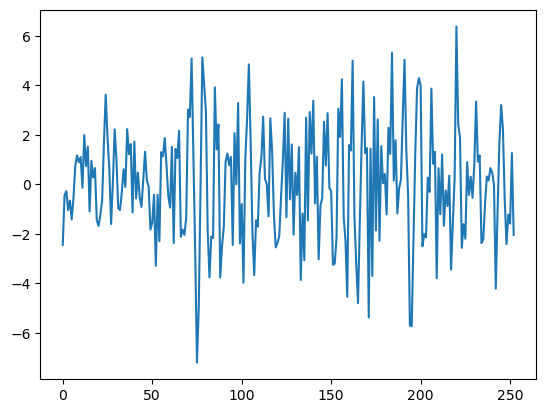

In [16]:
n=250
theta = np. array([0.3, 0.2, -0.7])
sigma = 1.5
sample = ar_p(n, theta, sigma)
plt.plot(sample)

In [17]:
h = 500
n1 = 20
n2 = 15
theta = np. array([0.3, 0.2, -0.7])
sigma = 1.5
alpha = 0.1
result = seq_est_i_semiint(h, n1, n2, theta, sigma, alpha).reshape((1,7))
table = pd.DataFrame(result, columns = ('1-alpha','h','sigma', 'tau_max', 'Bias_est', 'ind_cover', 'semiint'))
table

,1-alpha,h,sigma,tau_max,Bias_est,ind_cover,semiint
0,0.9,500.0,1.5,686.0,0.05517,1.0,0.245218


здесь
1-alpha -- нижняя граница доверительной вероятности,
h -- параметр, отвечающий за средний объем выборки,
sigma^2 -- дисперсия управляющего шума процесса AR(1),
tau_max -- объем выборки,
Bias_est -- модуль смещения оценки,
ind_cover -- индикатор накрытия истинного значения параметра theta доверительным эллипсоидом,
semiint -- длина максимальной полуоси доверительного эллипсоида.

